In [1]:
!pip install jsonlines
!pip install sparqlwrapper
!pip install tqdm

import json

from SPARQLWrapper import SPARQLWrapper, JSON
import jsonlines
import pandas as pd
from tqdm import tqdm

# Analyze Wikidata gender distribution

In [3]:
entity_path = "../../wikidata_humans/wikidata_all_human_entities.jsonl"

In [4]:
ids = []
genders = []
dobs = []
pobs = []
with open(entity_path) as json_file:
    ent_list = list(json_file)

for entry in ent_list:
      entry = json.loads(entry)
      ids += [entry["entity_id"]]
      genders += [entry["gender"]]
      dobs += [entry["DOB"]]
      pobs += [entry["POB"]]


### a) Load gender map from json

In [5]:
with open("wikidata_genders.json", "r") as f:
    gender_map = json.load(f)["map"]

### b) Create gender map through SPARQL queries

In [5]:
user_agent = 'AngelieKraftUHH (angelie.kraft@uni-hamburg.de)'
sparql = SPARQLWrapper("https://query.wikidata.org/sparql", agent=user_agent)

In [3]:
gender_map = {}
for g in list(set(genders)):
    sparql.setQuery(f"""
    SELECT  *
    WHERE 
    {{
        wd:{g} rdfs:label ?label .
        FILTER (langMatches( lang(?label), "EN" ) )
    }}
    """)
    sparql.setReturnFormat(JSON)
    query_result = sparql.query().convert()

    try:
        gender_map[g] = query_result["results"]["bindings"][0]["label"]["value"]
    except:
        pass
  

In [4]:
gender_map[""] = "unknown"

### Compute frequencies

In [6]:
from collections import Counter

genders_decoded = [gender_map[g] for g in genders]
gender_frequencies = dict(Counter(genders_decoded))
gender_frequencies

{'male': 6140593,
 'female': 1988367,
 'trans woman': 1387,
 'unknown': 2080255,
 'non-binary': 588,
 'trans man': 310,
 'intersex': 76,
 'faʻafafine': 5,
 'hijra': 3,
 'eunuch': 142,
 'agender': 19,
 'androgyne': 3,
 'genderqueer': 39,
 'undisclosed gender': 1,
 'transgender': 24,
 'genderfluid': 44,
 'travesti': 4,
 'cisgender female': 21,
 'two-spirit': 16,
 'transmasculine': 8,
 'bigender': 6,
 'assigned male at birth': 1,
 'neutrois': 4,
 'indefinite': 1,
 'takatāpui': 3,
 'female organism': 5,
 'transfeminine': 6,
 'Jamaica': 1,
 'neutral sex': 5,
 'muxe': 2,
 'intersex person': 3,
 'pangender': 1,
 'queer': 1,
 'Alien': 1,
 'māhū': 1,
 'X-gender': 1,
 'demiboy': 1,
 "'akava'ine": 1,
 'vakasalewalewa': 1,
 'third gender': 1}

### Group certain gender groups for visualization

In [7]:
keys = ["female", "trans woman", "male", "trans man", "unknown", "non-binary/intersex/agender/other"]
grouped_frequencies = dict(zip(keys, [0]*len(keys)))
for k,v in gender_frequencies.items():
    if k in ["trans woman", "trans man", "male"]:
        grouped_frequencies[k] += v
    elif k in ["female", "cisgender female"]:
        grouped_frequencies["female"] += v
    elif k in ["unknown", "undisclosed gender"]:
        grouped_frequencies["unknown"] += v
    else:
        grouped_frequencies["non-binary/intersex/agender/other"] += v

In [8]:
grouped_frequencies = {k: v for k, v in sorted(grouped_frequencies.items(), key=lambda item: item[1], reverse=True)}

In [12]:
grouped_frequencies

{'male': 6140593,
 'unknown': 2080256,
 'female': 1988388,
 'trans woman': 1387,
 'non-binary/intersex/agender/other': 1017,
 'trans man': 310}

In [9]:

!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

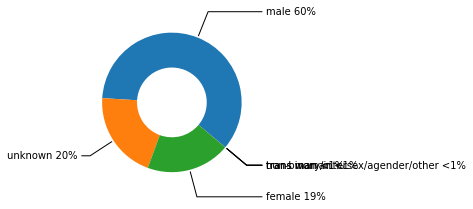

In [14]:
import numpy as np
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
total = sum(grouped_frequencies.values())
labels = ["/\n".join(k.split("/")) for k, v in grouped_frequencies.items()]
#labels = list(grouped_frequencies.keys())
#sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
def my_autopct(pct):
    return ('%.0f' % pct) + "%" if pct > 1 else '<1%'
explode = (0, 0, 0, 0.2, 0.2, 0.2)
#plt.pie(grouped_frequencies.values(), labels=labels,  explode=[0.10]*len(grouped_frequencies), autopct=my_autopct)
wedges, texts  = ax.pie(grouped_frequencies.values(), wedgeprops=dict(width=0.5), startangle=-40)

kw = dict(arrowprops=dict(arrowstyle="-"), va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f"{labels[i]} {my_autopct(list(grouped_frequencies.values())[i] / total * 100)}", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

#plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
#           fontsize=8)
plt.savefig('wikidata_gender_distr_Oct2022.png', dpi=300)
plt.tight_layout()
plt.show()

In [11]:
save_dict = {}
save_dict["map"] = gender_map
save_dict["frequencies"] = gender_frequencies
save_dict["grouped_frequencies"] = grouped_frequencies

with open("wikidata_genders.json", "w") as f:
    json.dump(save_dict, f)

In [6]:
kelm_path = "../../kelm/kelm_generated_corpus.jsonl"
kelm_entities_path = "../../kelm/entities.jsonl"